**<center><font size=5>Radio Signals Classification by SETI Data 👽</font></center>**
<center><font size=4>By Ben Shaver and Coral Hayoun</font></center>

----
# Abstract

##### **"Are we alone in the Universe?"**

It's one of the most profound human questions. Finding evidance of extraterrestrial life can fundamentally change our understanding of life and can offer new insights into biology, technology and the potential future of humanity.
As technology improves, we're finding new and more powerful ways to seek for answers.

**SETI**, or *the Search for Extraterrestrial Intelligence*, is an ongoing scientific effort to detect signs of intelligent life beyond Earth by analyzing radio signals from space. Every night, using the Allen Telescope Array (ATA) in northern California, the SETI Institute scans the sky at various radio frequencies, observing star systems with known exoplanets, searching for faint but persistent signals.

In order to refine the search for alien communication and focus on meaninigful signal patterns only, the detection system should be able to seperate them from the numerous natural and human-made radio emissions.


In this project, we will use our machine learning skills to accurately classify these signals into seven pre-defined categories, so that each category represents a different signal characteristics. This may allow the signal detection system to make better observational decisions and increase the efficiency of the nightly scans.

<br></br>
<center><img src="https://i.pinimg.com/originals/89/e6/91/89e6912b1225c43ed18b7c2b31069f77.jpg" width="600"></center>

(from [SETI Data - Kaggle competition](https://www.kaggle.com/datasets/tentotheminus9/seti-data)) <br></br>

----

##### **Table of Contents**
- <a href='#1'>1. Initial Settings | ⚙️</a>
- <a href='#2'>2. Exploratory Data Analysis | 🔦</a>
  - <a href='#2_1'>2.1. Data Loading</a>
  - <a href='#2_2'>2.2. Data Visualizing</a>
  - <a href='#2_3'>2.3. Data Statistics</a>
    - <a href='#2_3_1'>2.3.1 Needles Distribution</a>
    - <a href='#2_3_2'>2.3.2 Basic Statistical Features</a>
  - <a href='#2_4'>2.4. Noise Analyzing</a>
    - <a href='#2_4_1'>2.4.1 Gaussian Noise</a>
    - <a href='#2_4_2'>2.4.2 Frequency Domain Analysis</a>
    - <a href='#2_4_3'>2.4.3 Wavelet Transform Analysis</a>
  - <a href='#2_5'>2.5. Clustering</a>
    - <a href='#2_5_1'>2.5.1 Data Respresentation</a>
      - <a href='#2_5_1_1'>2.5.1.1. Vertical Detail Coefficients (cV)</a>
      - <a href='#2_5_1_2'>2.5.1.2. SIFT</a>
      - <a href='#2_5_1_3'>2.5.1.3. HOG</a>
      - <a href='#2_5_1_4'>2.5.1.4. LBP</a>
    - <a href='#2_5_2'>2.5.2 Dimensionality Reduction - PCA</a>
    - <a href='#2_5_3'>2.5.3 K-means</a>
    
  ----

# <a id='1'>1. Initial Settings | ⚙️</a>

##### 1. Install Libraries

In [2]:
%pip install -q pywt

##### 2. Import Libraries

In [66]:
# For operating system and file system
import os
import time
import logging
from pathlib import Path

# For basic functionallity
import math

# For data manipulation and analysis
import numpy as np
import pandas as pd

# For frequency analysis
from scipy.fft import fft
import pywt

# For Computer Vision Library
import cv2
from skimage import exposure
from skimage.feature import hog
from skimage.feature import local_binary_pattern

# For Deep Learning
import tensorflow as tf

# For Machine Learning
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import shuffle

# For data manipulation
from skimage.transform import resize
from skimage.restoration import estimate_sigma

# For data visualization
from PIL import Image
import matplotlib.pyplot as plt
import imageio.v3 as iio
from scipy.stats import skew
import seaborn as sns

# For model persistence
import joblib

# For warning filtering
import warnings

In [4]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

##### 3. Libraries Version

In [5]:
print('np version:',np.__version__)
print('pd version:',pd.__version__)
print('tf version:',tf.__version__)
print('sklearn version:',sklearn.__version__)

np version: 1.26.4
pd version: 2.1.4
tf version: 2.16.1
sklearn version: 1.2.2


##### 4. Configuration

In [3]:
class CFG:
    # ------------------------------------#
    # Basic
    # ------------------------------------#
    debug = True
    runOnKaggle = False
    epochs = 1
    train_batch_size = 64
    validation_batch_size = 20
    data_augmentation_size = 5000
    test_batch_size = 64
    seed = 42
    k_fold = 4

    # ------------------------------------#
    # Paths
    # ------------------------------------#
    if runOnKaggle:
        base_folder_path = '/kaggle/input/seti-data/primary_small'
        tmp_storage_path = '/kaggle/tmp'
        workdir_folder_path = '/kaggle/working'
        logging_file = '/kaggle/logging.txt'
    else:
        base_folder_path = os.path.abspath('../../../Downloads/SETI Data/primary_small')
        tmp_storage_path = 'tmp'
        workdir_folder_path = 'working'
        logging_file = 'logging.txt'

    train_folder_path = f'{base_folder_path}/train'
    validation_folder_path = f'{base_folder_path}/valid'
    test_folder_path = f'{base_folder_path}/test'

# ------------------------------------#
# On Debug
# ------------------------------------#
if CFG.debug:
    CFG.epochs = 1
    CFG.train_batch_size = 50
    CFG.validation_batch_size = 25
    CFG.test_batch_size = 50
    CFG.data_augmentation_size = 500

##### 5. Utils Methods

In [94]:
def print_with_underline(text):
  underline = '\033[4m'
  reset = '\033[0m'
  print(f'{underline}{text}{reset}')

def get_files_in_folder(folder_path):
  return [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

def plot_features_distribution(features_list, features_df, figsize=(8, 4)):
  for feature in features_list:
      plt.figure(figsize=figsize)

      # sns.histplot needs convertion from float16 to float32
      features_df[feature] = features_df[feature].astype('float32')
      sns.histplot(features_df[features_df['category'] == 1][feature], bins=30, kde=True, color='blue', label='brightpixel')
      sns.histplot(features_df[features_df['category'] == 2][feature], bins=30, kde=True, color='orange', label='narrowband')
      sns.histplot(features_df[features_df['category'] == 3][feature], bins=30, kde=True, color='red', label='narrowbanddrd')
      sns.histplot(features_df[features_df['category'] == 4][feature], bins=30, kde=True, color='yellow', label='noise')
      sns.histplot(features_df[features_df['category'] == 5][feature], bins=30, kde=True, color='pink', label='squarepulsednarrowband')
      sns.histplot(features_df[features_df['category'] == 6][feature], bins=30, kde=True, color='purple', label='squiggle')
      sns.histplot(features_df[features_df['category'] == 7][feature], bins=30, kde=True, color='brown', label='squigglesquarepulsednarrowband')
      
      plt.title(f'Distribution of {feature} by Category')
      plt.xlabel(feature)
      plt.ylabel('Count')
      plt.legend(title='Categories', loc='upper left', fontsize='small', framealpha=0.9, bbox_to_anchor=(1, 1))
      plt.show()

def log(message, shouldPrint=False):
  if shouldPrint:
    print(message)
  logging.info(message)

def save_model(model, name):
  joblib.dump(model, f'{CFG.workdir_folder_path}/{name}.pkl')
  
def load_model(name):
  return joblib.load(f'{CFG.workdir_folder_path}/{name}.pkl')

def get_duration(start_time):
  return (time.time() - start_time) / 60

##### 6. Initial Methods

In [ ]:
# Create tmp Directory
if not os.path.exists(CFG.tmp_storage_path):
    os.makedirs(CFG.tmp_storage_path)

# Create working Directory
if not os.path.exists(CFG.workdir_folder_path):
    os.makedirs(CFG.workdir_folder_path)
    
# Create logging file
if not os.path.exists(CFG.logging_file):
    with open(CFG.logging_file, 'w'):
        pass

# Setup logger
logging.basicConfig(
    level=logging.INFO,  
    format='%(asctime)s - %(message)s',  
    filename=CFG.logging_file,  
    filemode='a'  
  )

# Remove unnecessary warnings
warnings.filterwarnings('ignore')

----

# <a id='2'>2. Exploratory Data Analysis | 🔦</a>


With our libraries and configurations set up, we can begin the exploratory data analysis (or EDA).

The **goal of EDA** is to understand the data underlying structure and patterns, identify important variables, detect outliers and anomalies and formulate hypotheses for further investigation. 

This process includes examining the distribution of the data, identifying patterns and trends, applying dimensionality reduction and clustering techniques, and visualizing the data to gain insights.

### <a id='2_1'>2.1. Data Loading</a>

Even though our task sounds like a *signal* classification problem - it is actually an *image* classification problem. We are provided with radio spectrograms *images* - a visual representation of the spectrum frequencies of a signal as it varies with time. <br></br>
To be accurate, our dataset consists of:
- Three folders named `train`, `valid` and `test`.
- For each of these three folders, there are seven more folders inside it - named **brightpixel**, **narrowband**, **narrowbanddrd**, **noise**, **squarepulsednarrowband**, **squiggle** and **squigglesquarepulsednarrowband**, which are the seven categories of our radio signals.
- For each of these seven categories folders, there are data samples files matching their folder category, as `.png` files.
<br></br>

In [7]:
def count_data_samples_per_category(base_folder):
    data_samples_amount = 0

    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)

        if os.path.isdir(subfolder_path):
            subfolder_files = get_files_in_folder(subfolder_path)
            print(f'- for {subfolder}, there are {len(subfolder_files)} files')
            data_samples_amount += len(subfolder_files)
    
    print(f'in total, there are {data_samples_amount} files \n')

# Main
print_with_underline('train files:')
count_data_samples_per_category(CFG.train_folder_path)

print_with_underline('validation files:')
count_data_samples_per_category(CFG.validation_folder_path)

print_with_underline('test files:')
count_data_samples_per_category(CFG.test_folder_path)

train files:
- for brightpixel, there are 800 files
- for narrowband, there are 800 files
- for narrowbanddrd, there are 800 files
- for noise, there are 800 files
- for squarepulsednarrowband, there are 800 files
- for squiggle, there are 800 files
- for squigglesquarepulsednarrowband, there are 800 files
in total, there are 5600 files 

validation files:
- for brightpixel, there are 100 files
- for narrowband, there are 100 files
- for narrowbanddrd, there are 100 files
- for noise, there are 100 files
- for squarepulsednarrowband, there are 100 files
- for squiggle, there are 100 files
- for squigglesquarepulsednarrowband, there are 100 files
in total, there are 700 files 

test files:
- for brightpixel, there are 100 files
- for narrowband, there are 100 files
- for narrowbanddrd, there are 100 files
- for noise, there are 100 files
- for squarepulsednarrowband, there are 100 files
- for squiggle, there are 100 files
- for squigglesquarepulsednarrowband, there are 100 files
in tota

As we can see, we are provided with **5600 train examples** (where each category has 800 data samples euqally), **700 validation examples** (where each category has 100 data samples euqally) and **70The dataset is not that large, which may limit our model's predictions accuracy. If this will be the case - the dataset may be expanded with additional synthetic samples to enhance data diversity.

Now, let's check some basic information about our data:

In [ ]:
def get_image_dimensions(image_path):
    image = Image.open(image_path)

    return image.size

In [17]:
def get_images_dimensions(base_folder):
    files_dimensions = []

    for category in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category)

        if os.path.isdir(category_path):
            for category_file in get_files_in_folder(category_path):
                width, height = get_image_dimensions(os.path.join(category_path, category_file))
                files_dimensions.append([width, height, category])

    return pd.DataFrame(files_dimensions, columns=['width', 'height', 'category'])

def display_images_dimensions(dimensions_df):
    if dimensions_df['width'].nunique() == 1 and dimensions_df['height'].nunique() == 1:
        width = dimensions_df['width'].iloc[0]
        height = dimensions_df['height'].iloc[0]
        print(f'image size is {width}x{height}')
    else:
        print('different images have different dimensions')   

# Main
print_with_underline('train files:')
display_images_dimensions(get_images_dimensions(CFG.train_folder_path))


print_with_underline('\nvalidation files:')
display_images_dimensions(get_images_dimensions(CFG.validation_folder_path))

print_with_underline('\ntest files:')
display_images_dimensions(get_images_dimensions(CFG.test_folder_path))

train files:
image size is 512x384

validation files:
image size is 512x384

test files:
image size is 512x384


In [ ]:
def is_image_grayscale(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if len(image.shape) < 3:
        return True
    elif image.shape[2] == 1:
        return True
    else:
        return False

In [23]:
def display_images_type(base_folder):
    rgb_files = 0
    grayscale_files = 0

    for category in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category)

        if os.path.isdir(category_path):
            for file in get_files_in_folder(category_path):
                if is_image_grayscale(os.path.join(category_path, file)):
                    grayscale_files += 1
                else:
                    rgb_files += 1
    
    print(f'- {rgb_files * 100 / (rgb_files + grayscale_files)}% of the images are RGB')
    print(f'- {grayscale_files * 100 / (rgb_files + grayscale_files)}% of the images are grayscale')

# Main
print_with_underline('train files:')
display_images_type(CFG.train_folder_path)

print_with_underline('\nvalidation files:')
display_images_type(CFG.validation_folder_path)

print_with_underline('\ntest files:')
display_images_type(CFG.test_folder_path)

train files:
- 100.0% of the images are RGB
- 0.0% of the images are grayscale

validation files:
- 100.0% of the images are RGB
- 0.0% of the images are grayscale

test files:
- 100.0% of the images are RGB
- 0.0% of the images are grayscale


Looks like all of our dataset samples have identical size and type - RGB and 512x384, so it is likely that applying changes (like resizing) to the images should affect them all quite similarly.

Now, Before starting to work with these data samples, we need to make sure that our samples are valid and suitable for analysis and modeling:
- That all files are with the expected `.png` extension
- That there are no corrupted files
- That there are no blank content files

In [30]:
def is_file_extension_valid(image_path):
    image_extension = Path(image_path).suffix.lower()
    
    return image_extension in ['.png']

def is_file_content_blank(image):
    image_np = np.array(image)

    return np.all(image_np == image_np.flat[0])

In [32]:
def detect_invalid_data_samples(base_folder):
    corrupted_files = []
    blank_files = []
    invalid_extension_files = []

    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)

        if os.path.isdir(subfolder_path):
            for subfolder_file in get_files_in_folder(subfolder_path):
                try:
                    image_path = os.path.join(subfolder_path, subfolder_file)
                    with Image.open(image_path) as image:
                        image.verify()
                        # Verify function changes image object to invalid state so it shoud be reopen for further processing
                        image = Image.open(image_path)

                        if not is_file_extension_valid(image_path):
                            invalid_extension_files.append(subfolder_file)

                        if is_file_content_blank(image):
                            blank_files.append(subfolder_file)
                
                except (IOError, SyntaxError) as e:
                    corrupted_files.append(subfolder_file)
    
    print(f'- there are {len(corrupted_files)} corrupted files')
    print(f'- there are {len(blank_files)} blank files')
    print(f'- there are {len(invalid_extension_files)} invalid extension files')
    
# Main
print_with_underline('train files:')
detect_invalid_data_samples(CFG.train_folder_path)

print_with_underline('\nvalidation files:')
detect_invalid_data_samples(CFG.validation_folder_path)

print_with_underline('\ntest files:')
detect_invalid_data_samples(CFG.test_folder_path)

train files:
- there are 0 corrupted files
- there are 0 blank files
- there are 0 invalid extension files

validation files:
- there are 0 corrupted files
- there are 0 blank files
- there are 0 invalid extension files

test files:
- there are 0 corrupted files
- there are 0 blank files
- there are 0 invalid extension files


We've just confirmed that all our files have the correct extension and free from corruption or blank content. Before moving to further investigation, let's create a data frame of our samples for easier future work:

In [48]:
def category_to_int_mapper(category):
    mapping = {
        'brightpixel': 1,
        'narrowband': 2,
        'narrowbanddrd': 3,
        'noise': 4,
        'squarepulsednarrowband': 5,
        'squiggle': 6,
        'squigglesquarepulsednarrowband': 7
    }

    return mapping[category]

def create_samples_data_frame(base_folder):
    data = []
    
    for category in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category)
        
        if os.path.isdir(category_path):
            for category_file in get_files_in_folder(category_path):
                file_path = os.path.join(category_path, category_file)
                file_id = os.path.splitext(category_file)[0]

                data.append([file_id, file_path, category_to_int_mapper(category)])
    
    return pd.DataFrame(data, columns=['file_id', 'file_path', 'category'])

# Main
train_df = create_samples_data_frame(CFG.train_folder_path)
validation_df = create_samples_data_frame(CFG.validation_folder_path)
test_df = create_samples_data_frame(CFG.test_folder_path)

We've done loading our dataset and make sure it is valid and reliable. Now we can move to deeper investigation:

### <a id='2_2'>2.2. Data Visualizing</a>

As we already mentained, our data samples are `.png` files, arranged in their belonging categories folders. Let's start by writing the general functions for spectogram file visualization:

In [33]:
def get_image_path(base_folder, category, image_id):
    return '{}/{}/{}.png'.format(base_folder, category, image_id)

def get_grayscale_image(file_path):
    image = iio.imread(file_path)
    
    return cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)

def display_grayscale_image(files_path):
    _, axes = plt.subplots(1, 3, figsize=(15,5))

    for ax, file_path in zip(axes, files_path):
        image = get_grayscale_image(file_path)
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        
    plt.show()

Now, we can move forward to explore and visualize the seven categories of radio signals, for better understanding of our data:<br></br>

1. **Brightpixel**: refers to a localized region in a spectrogram that shows a significant increase in signal strength compared to the surrounding noise. It appears as a very bright isolated spot or pixel in the frequency-time plot. They can occur due to natural radio interference or brief, transient events in the environment. They are typically regarded as noise unless they show a consistent pattern or occur across multiple channels or time intervals, suggesting a potential artificial source.

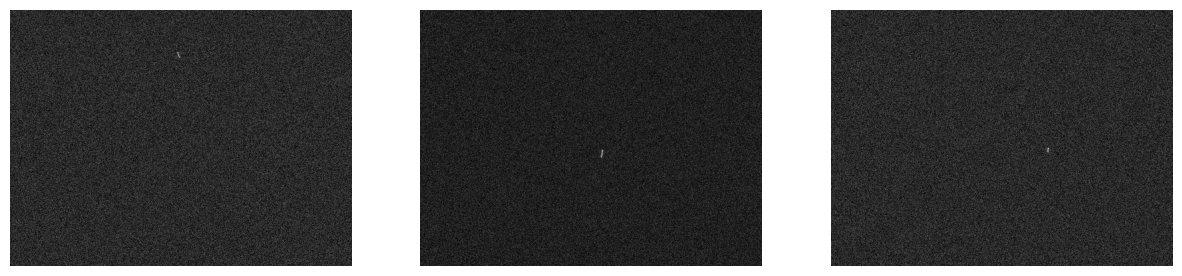

In [38]:
paths = [
    get_image_path(CFG.train_folder_path, 'brightpixel', '423_brightpixel'),
    get_image_path(CFG.train_folder_path, 'brightpixel', '49_brightpixel'),
    get_image_path(CFG.train_folder_path, 'brightpixel', '175_brightpixel')
]

display_grayscale_image(paths)

2. **Narrowband**: referes to a very small bandwidth, meaning that it occupies a narrow range of frequencies. In a spectrogram, it appears as a vertical line, indicating that the signal is concentrated at a specific frequency over a period of time. Narrowband signals are of particular interest in SETI because natural astrophysical sources rarely produce such narrow frequency emissions. A true narrowband signal would suggest a non-natural origin, potentially indicating technology.

In [40]:
paths = [
    get_image_path(CFG.train_folder_path, 'narrowband', '165_narrowband'),
    get_image_path(CFG.train_folder_path, 'narrowband', '45_narrowband'),
    get_image_path(CFG.train_folder_path, 'narrowband', '61_narrowband')
]

display_grayscale_image(paths)

3. **Narrowbanddrd** (Narrowband Drift): efers to a narrowband signal that shows a frequency drift over time, appearing as a slanted line in the spectrogram. This drift may occur because the source of the signal is moving relative to the observer. The drift in frequency might be due to the Doppler effect caused by relative motion between the source and the receiver, so these signals could indicate a moving or rotating extraterrestrial transmitter.

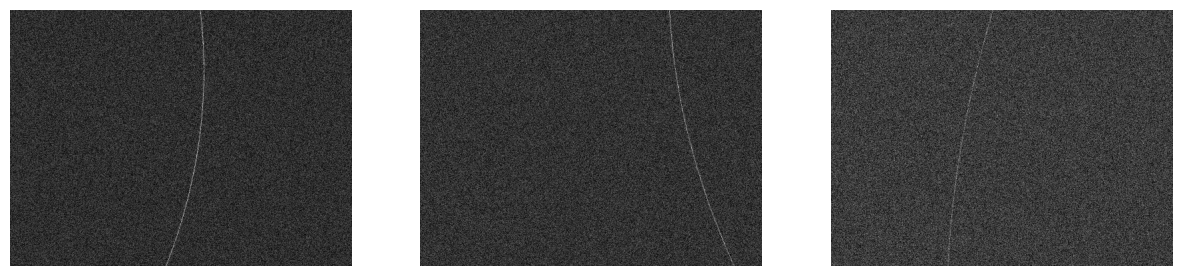

In [41]:
paths = [
    get_image_path(CFG.train_folder_path, 'narrowbanddrd', '118_narrowbanddrd'),
    get_image_path(CFG.train_folder_path, 'narrowbanddrd', '46_narrowbanddrd'),
    get_image_path(CFG.train_folder_path, 'narrowbanddrd', '202_narrowbanddrd')
]

display_grayscale_image(paths)

4. **Noise**: refers to any signal or pattern that does not exhibit a clear or consistent structure, making it unlikely to be of artificial origin. It may manifest as random fluctuations in intensity across the spectrogram. Noise signal might be caused by natural sources, such as cosmic background radiation or interference from Earth-based technology and it generally does not suggest an extraterrestrial source. In SETI, noise reduction is crucial for identifying true candidate signals.

In [42]:
paths = [
    get_image_path(CFG.train_folder_path, 'noise', '761_noise'),
    get_image_path(CFG.train_folder_path, 'noise', '106_noise'),
    get_image_path(CFG.train_folder_path, 'noise', '215_noise')
]

display_grayscale_image(paths)

5. **Squarepulseandnarrowband**: This type of signal combines characteristics of both square pulse and narrowband signals. It exhibits a narrow frequency width like narrowband signals but appears in bursts or square pulse-like patterns over time. The combination of narrowband and square pulses could suggest a modulated signal or some form of structured emission, which may be indicative of technology.

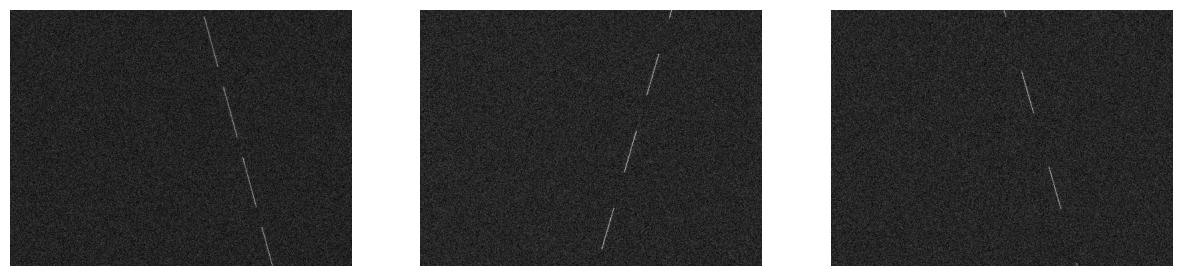

In [43]:
paths = [
    get_image_path(CFG.train_folder_path, 'squarepulsednarrowband', '116_squarepulsednarrowband'),
    get_image_path(CFG.train_folder_path, 'squarepulsednarrowband', '65_squarepulsednarrowband'),
    get_image_path(CFG.train_folder_path, 'squarepulsednarrowband', '147_squarepulsednarrowband')
]

display_grayscale_image(paths)

6. **Squiggle**: Squiggle signals exhibit a curvy or wavy pattern in the spectrogram. Their frequency varies in a more irregular and dynamic way compared to narrowbanddrd signals, leading to a squiggly appearance. While the origins of squiggle signals can sometimes be attributed to natural astrophysical processes, like pulsar emissions, they may also suggest a non-standard form of modulation in an artificial transmission.

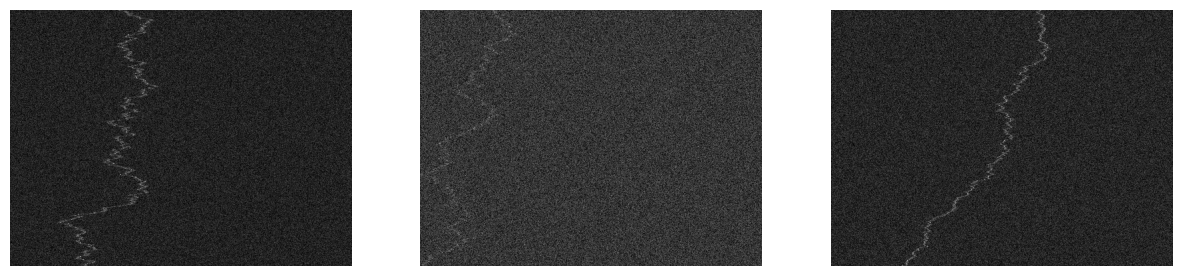

In [44]:
paths = [
    get_image_path(CFG.train_folder_path, 'squiggle', '21_squiggle'),
    get_image_path(CFG.train_folder_path, 'squiggle', '83_squiggle'),
    get_image_path(CFG.train_folder_path, 'squiggle', '131_squiggle')
]

display_grayscale_image(paths)

7. **Squigglesquarepulseandnarrowband**: This category combines features from squiggle, squarepulse, and narrowband signal types. In a spectrogram, it may appear as a complex pattern consisting of wavy lines (squiggles), square pulses, and narrowband components, potentially overlapping or interwoven. Such complex signal patterns are intriguing in the search for extraterrestrial intelligence because they might imply a sophisticated modulation technique or a mix of different signal types. They are more challenging to analyze due to their varied nature but could potentially carry meaningful information.

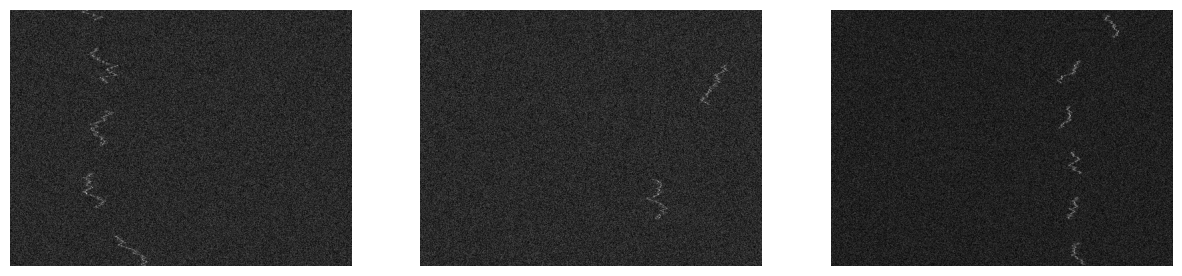

In [45]:
paths = [
    get_image_path(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '181_squigglesquarepulsednarrowband'),
    get_image_path(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '129_squigglesquarepulsednarrowband'),
    get_image_path(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '249_squigglesquarepulsednarrowband')
]

display_grayscale_image(paths)

Interesting. We can already see visual similarity between different signals types, like: Squigglesquarepulseandnarrowband-Squiggle, Narrowband-Narrowbanddrd-Squarepulseandnarrowband and Noise-Brightpixel. In the next sections, we will observe these categories characteristics closely, so we will try to find distinguish features among them:

### <a id='2_3'>2.3. Feature Extraction</a>
**Feature extraction** is a crucial step in analyzing our signal dataset, as it involves identifying distinctive characteristics that can effectively differentiate between various signal types. By quantifying attributes such as amplitude, frequency, and statistical measures, we can enhance our understanding of each category's unique properties. This process not only aids in classification tasks but also improves the overall accuracy of our signal detection models.

#### <a id='2_3_1'>2.3.1 Pixels Statistics</a>

We will start our *Feature extraction* by exploring the **histogram** of random signals. Performing a **histogram** over our signals data, which represents the distribution of pixel intensities in an image, helps us see how signal characteristics, like amplitude or frequency, are distributed. This visualization makes it easier to identify patterns and detect anomalies in the signals.

In order to preforme it, we've decided to work on our images grayscale respresentation and divide their pixels into 4 group by brightness ranges, marked as Q1-Q4:

In [36]:
pixel_value_range = 256

def image_brightness_ranges(grayscale_image):
    ranges = [(0, 64), (64, 128), (128, 192), (192, 256)]
        
    counts = []
    for lower, upper in ranges:
        counts.append(np.sum((grayscale_image >= lower) & (grayscale_image < upper)))

    return counts

In [38]:
def plot_pixel_brightness_histogram(base_folder, category, image_id):
    _, axis = plt.subplots(1, 2, figsize=(10,2)) 
    
    grayscale_image = get_grayscale_image(get_image_path(base_folder, category, image_id))
    
    axis[0].set_title(category)
    axis[0].imshow(grayscale_image, aspect='auto', cmap='gray')
    
    # Determine the quartiles
    q1 = (pixel_value_range / 4) * 1
    q2 = (pixel_value_range / 4) * 2
    q3 = (pixel_value_range / 4) * 3
    q4 = (pixel_value_range / 4) * 4
    
    axis[1].hist(grayscale_image.flatten(), bins=pixel_value_range, density=True, color='blue', alpha=0.3)
    axis[1].set_xlim(0, 255)
    
    # Add vertical lines for quartiles
    axis[1].axvline(q1, color='black', linestyle='--')
    axis[1].axvline(q2, color='black', linestyle='--')
    axis[1].axvline(q3, color='black', linestyle='--')

    # Add text annotations for quartiles
    axis[1].text(q1 / 2, 0.02, 'Q1', fontsize=12, ha='center')
    axis[1].text((q1 + q2) / 2, 0.02, 'Q2', fontsize=12, ha='center')
    axis[1].text((q2 + q3) / 2, 0.02, 'Q3', fontsize=12, ha='center')
    axis[1].text((q3 + 256) / 2, 0.02, 'Q4', fontsize=12, ha='center')

    # Add labels and title
    axis[1].set_xlabel('Pixel Color (Brightness)')
    axis[1].set_ylabel('Normalized Frequency')
    axis[1].set_title(f"Brightness counts: {image_brightness_ranges(grayscale_image)}")
    axis[1].grid(True)
    
    plt.show

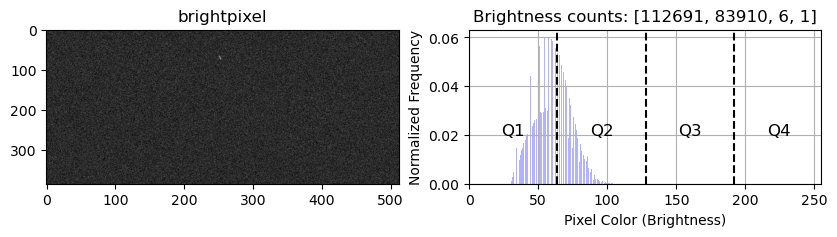

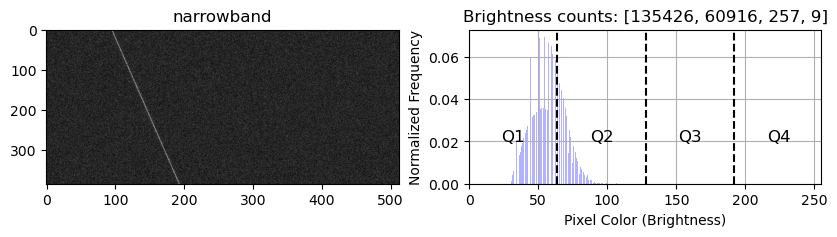

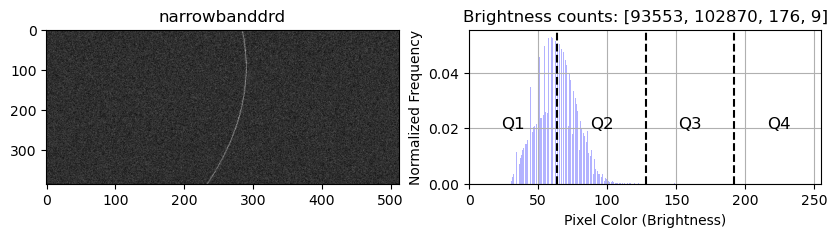

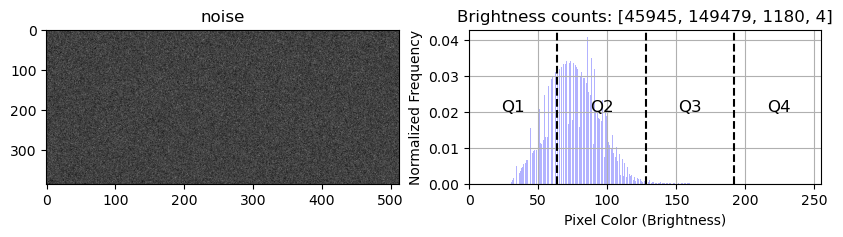

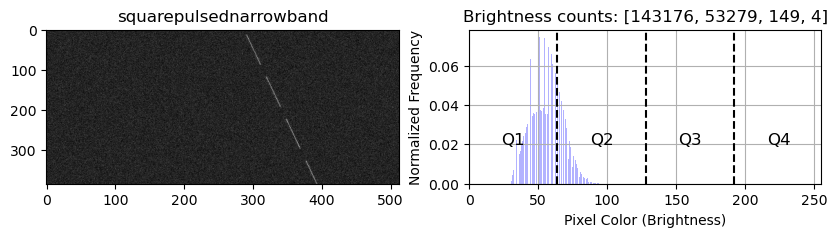

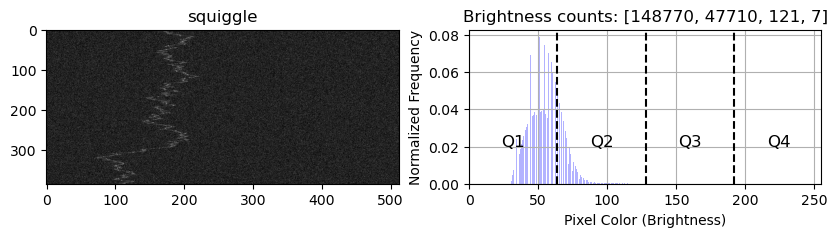

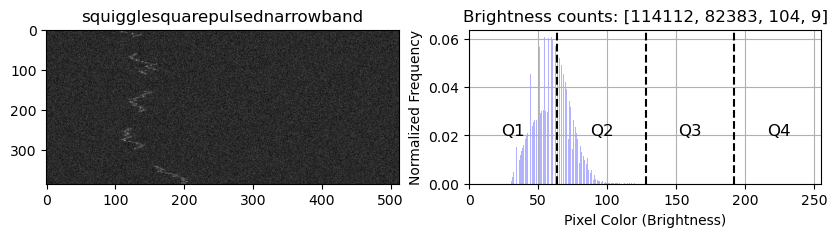

In [39]:
# Main
plot_pixel_brightness_histogram(CFG.train_folder_path, 'brightpixel', '423_brightpixel')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'narrowband', '165_narrowband')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'narrowbanddrd', '118_narrowbanddrd')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'noise', '761_noise')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'squarepulsednarrowband', '116_squarepulsednarrowband')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'squiggle', '21_squiggle')
plot_pixel_brightness_histogram(CFG.train_folder_path, 'squigglesquarepulsednarrowband', '181_squigglesquarepulsednarrowband')

Nice! we can see tiny differences between some of the categories histograms, but it certainly not enough. Besides the distinguish of the brightness of the pixel in each spectogram sample there is more job that should be done on the characteristics of pixel brightness distribution, such as mean, variance and skewness which all could help us:
- **Mean**  of the pixel brightness is the average pixel brightness.
- **Variance** is the measure of how much the values differ from the *mean*.
- **Skewness** is a statistical measure that describes the asymmetry of the distribution of data values around the *mean*. It helps us understand if the data distribution is skewed to the left or right of the *mean*.

In [43]:
def get_pixels_statistical_measures(grayscale_image):
    # Flatten the image to a 1D array of pixel intensities
    pixels = grayscale_image.flatten()
    
    return (np.mean(pixels), np.var(pixels), skew(pixels))

# Main
grayscale_image = get_grayscale_image(get_image_path(CFG.train_folder_path, 'narrowbanddrd', '118_narrowbanddrd'))
statistical_measure = get_pixels_statistical_measures(grayscale_image)

print(f'mean: {statistical_measure[0]}, variance: {statistical_measure[1]}, skewness: {statistical_measure[2]}')

mean: 64.49246215820312, variance: 213.2262005051598, skewness: 0.28370592528231536


Great, now we can explore these metrics over the entire training set:

In [49]:
statistical_measures_list = []

for _, row in train_df.iterrows():
    image_id = row['file_id']
    image = get_grayscale_image(row['file_path'])

    mean, variance, skewness = get_pixels_statistical_measures(image)

    statistical_measures_list.append({
        'id': row['file_id'],
        'category': row['category'],
        'mean': mean,
        'variance': variance,
        'skewness': skewness
    })

statistical_measures_df = pd.DataFrame(statistical_measures_list)

After collecting these features, let's analyze them:

c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

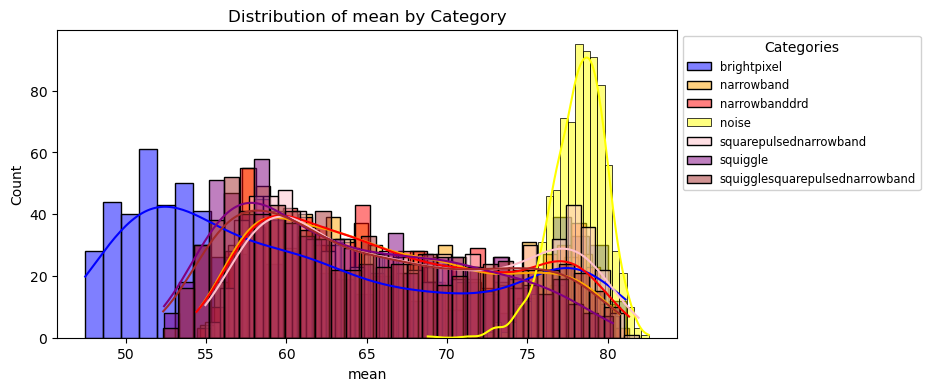

c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

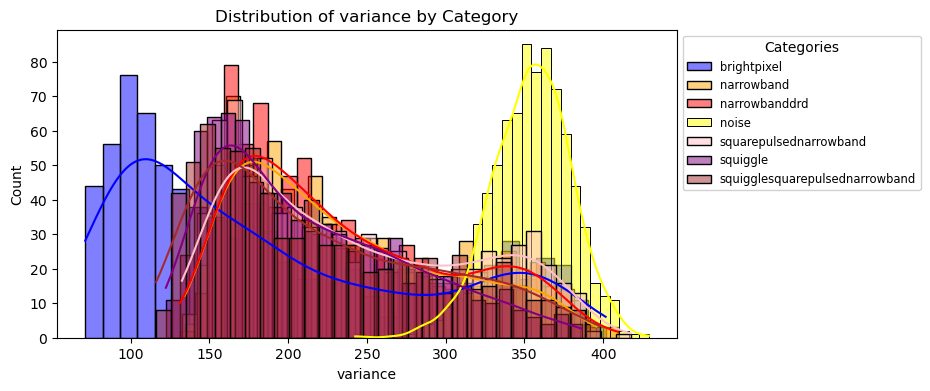

c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

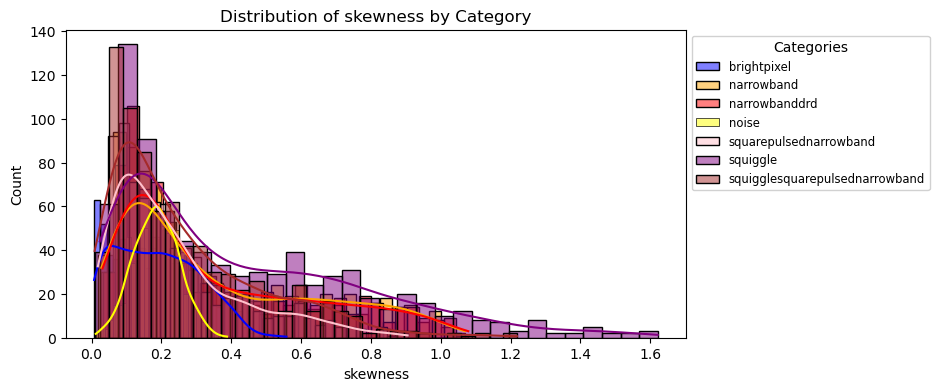

In [96]:
plot_features_distribution(['mean', 'variance', 'skewness'], statistical_measures_df)

Great! As we can see, the mean and the variance are exellent separators between the **noise** category to the rest, and can potentially be good separators between the **brightpixel** category to the rest as well. 

We will move now to our next feature:

#### <a id='2_3_2'>2.3.2 Gaussian Noise Analyzing</a>
`Gaussian Noise`, also known as normal noise, is a fundamental concept in signal processing and statistics. It is called *Gaussian* because its probability density function (*PDF*) follows a Gaussian (normal) distribution. By estimating the standard deviation of the Gaussian noise in the images, we can gain insights into the level of noise present and its impact on the image quality.

Let's analyze the Gaussian noise std using `estimate_sigma ` function, which based on frequency components decomposition in order to estimate the noise level in an image:

In [56]:
def get_gaussian_noise(image):
    return estimate_sigma(image, channel_axis=None, average_sigmas=True)

In [57]:
gaussian_noise_list = []

for _, row in train_df.iterrows():
    image_id = row['file_id']
    image = get_grayscale_image(row['file_path'])

    noise = get_gaussian_noise(image)

    gaussian_noise_list.append({
        'id': row['file_id'],
        'category': row['category'],
        'noise': noise
    })

gaussian_noise_df = pd.DataFrame(gaussian_noise_list)

Now we can analyze it as well:

c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

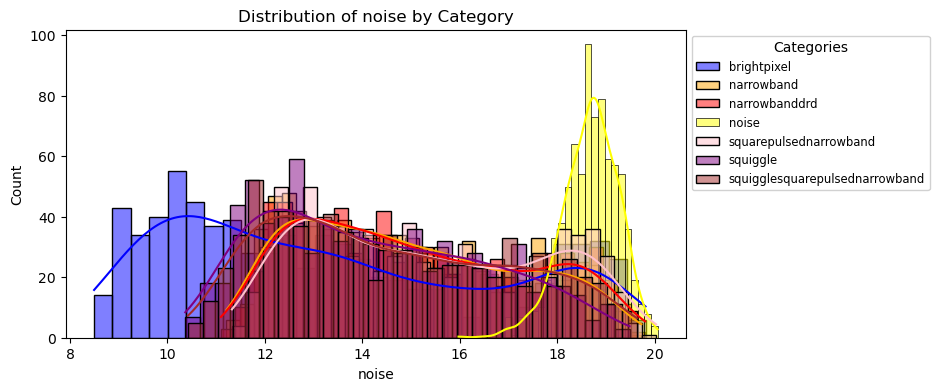

In [95]:
plot_features_distribution(['noise'], gaussian_noise_df)

Just like the *mean* and the *variance* indicators, it looks like the *Gaussian noise* indicator as also a great separator of **noise** category from the rest, and potentially of **brightpixel** as well.

In order to find some interesting insights about the rest of the categories, we will try now a different approach and analyse the frequencies of the spectrograms:

#### <a id='2_3_3'>2.3.3 Frequency Domain Analysis</a>

**Frequency Domain Analysis** is a powerful technique used in image processing to examine the frequency components of an image. This analysis transforms an image from the spatial domain (where pixel values are analyzed) to the frequency domain, where the image is represented by its frequency components.

The core of **Frequency Domain Analysis** is the `Fourier Transform`, which decomposes an image into its constituent frequencies. So, we need to start with understanding `Fourier Transform` meaning:

In the picture below, we can see the **Time Domain** representation of a audio signal, which shows the "loudness" (amplitude) of sounds wave changing with time. To better understand an audio signal, it is necessary to transform it into the **Frequency Domain** representation. This representation of a signal tells us what different frequencies are present in the signal.<br></br>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*e-_z80BnbHWyFTfRLblJ_w.gif" width="400"><br></br>
`Fourier Transform` is a mathematical concept that can *decompose a signal into its constituent frequencies*. In its 2D plot output, the x-axis represent the signal frequencies and the y-axis represent their magnitudes (amplitude size). There is also `Inverse Fourier Transform` concept, which is just the opposite of the Fourier Transform.<br></br>
 For a better understanding of Fourier Transform output - let's create two simple sine waves, with two different frequencies:  *amplitude = 1 and frequency = 3* and *amplitude = 2 and frequency = 11*.
 Now, we can combine them into a single signal, that will look like that - <br></br>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*WBldOpArJgDXIFs5g_JydA.png" width="400"><br></br>
The output of Fourier Transform will show two spikes  for the two frequencies and their magnitudes <br></br>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*aIyR6XoUYGJp0_3Ug6iEyA.png" width="400"><br></br>
For more information, you can read the article - [understand autio fft](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520)

Having said that, we can use `Fourier Transform` to analyze frequencies of each spectrogram, and to extract some interesting features:
1. **Peak Frequency**: Find the frequency with the highest amplitude in the Fourier-transformed data.
2. **Bandwidth**: Calculate the range of frequencies where the signal's power is concentrated.
3. **Spectral Centroid**: The "center of mass" of the frequency spectrum, which can indicate whether the frequency content is more concentrated at higher or lower frequencies.
4. **Number of Low Frequencies**: Correspond to slower oscillations or longer wavelengths in the signal. Often, the fundamental frequencies of sounds or   signals fall in the low-frequency range and they have higher amplitude than highers ones.
5. **Number of High Frequencies**: Correspond to faster oscillations or shorter wavelengths in the signal. In a spectrogram, these are represented by components that change rapidly over time.

In order to extract these features, we will start with apply `Fourier Transform` over our images using `fft` method and calculate its magnitude (which is the intensity of each frequency component in the transformed domain) and frequency bins (an array of indices that correspond to the frequency bins of the magnitude spectrum):

In [68]:
def apply_fft(grayscale_image):
    spectrogram = np.array(grayscale_image)

    # Create 1D array of the average power of frequencies over the entire spectrogram time span
    frequencies = np.mean(spectrogram, axis=1)
    frequencies_amount = len(frequencies)

    # Apply Fourier Transform to get amplitudes array of different frequencies components.
    frequencies_amplitudes = fft(frequencies)
    
    # Calculate the intensity of each frequency component in the transformed domain.
    magnitude = np.abs(frequencies_amplitudes[:frequencies_amount//2])

    # Create an array of the discrete frequency components that make up the original signal.
    frequency_bins = np.arange(len(magnitude))

    return magnitude, frequency_bins

Now we can use the magnitude and the frequency_bins to extract the features:

In [72]:
# Get the frequency with highest magnitude
def get_peak_frequnecy(magnitude, frequency_bins):
    return frequency_bins[np.argmax(magnitude)]

# Get the center of the mass of the spectrum
def get_spetcral_centroid(magnitude, frequency_bins):
    return np.sum(frequency_bins * magnitude) / np.sum(magnitude)

# Get the std of the frequencies distribution
def get_bandwidth(magnitude, frequency_bins, spectral_centroid):
    return np.sqrt(np.sum(((frequency_bins - spectral_centroid) ** 2) * magnitude) / np.sum(magnitude))

# Get low and high frequencies number by low frequnecies threshold
def get_low_and_high_frequencies(magnitude):
    low_frequencies = int(0.2 * len(magnitude))
    high_frequencies = len(magnitude) - low_frequencies

    return low_frequencies, high_frequencies

Now, we can extract these features from our traning set and analyze the results:

In [77]:
fft_features_list = []

for _, row in train_df.iterrows():
    image_id = row['file_id']
    image = get_grayscale_image(row['file_path'])

    magnitude, frequency_bins = apply_fft(image)
    
    spetcral_centroid = get_spetcral_centroid(magnitude, frequency_bins)
    low_frequencies, high_frequencies = get_low_and_high_frequencies(magnitude)

    fft_features_list.append({
        'id': row['file_id'],
        'category': row['category'],
        'peak': get_peak_frequnecy(magnitude, frequency_bins),
        'spetcral_centroid': spetcral_centroid,
        'bandwidth': get_bandwidth(magnitude, frequency_bins, spetcral_centroid),
        'low_frequencies': low_frequencies,
        'high_frequencies': high_frequencies
    })

fft_features_df = pd.DataFrame(fft_features_list)

c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

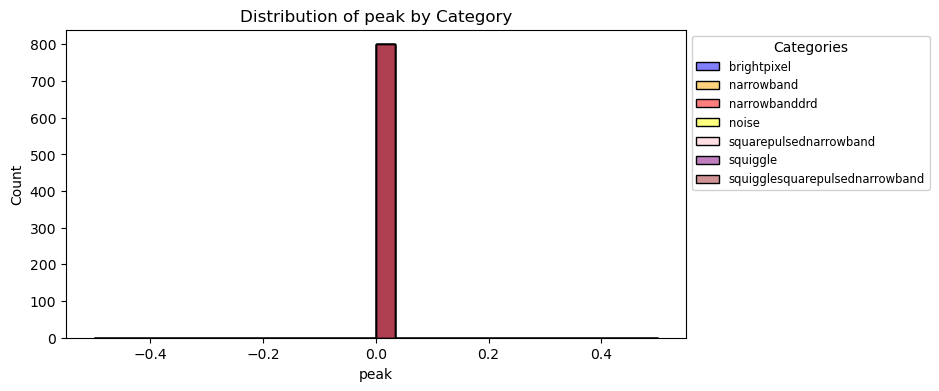

c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

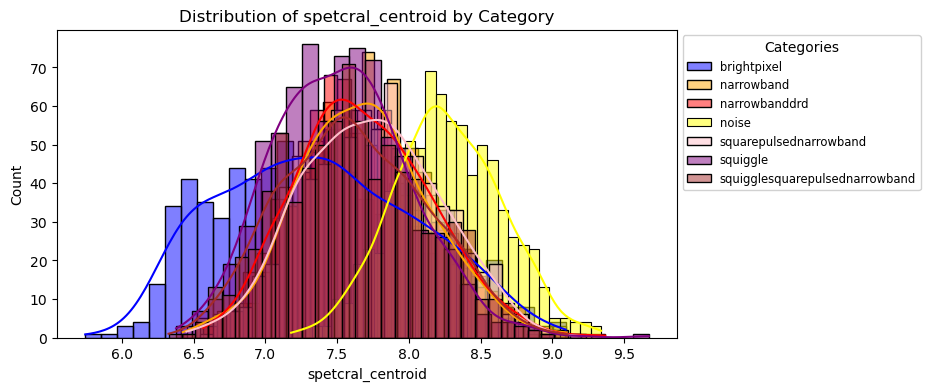

c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

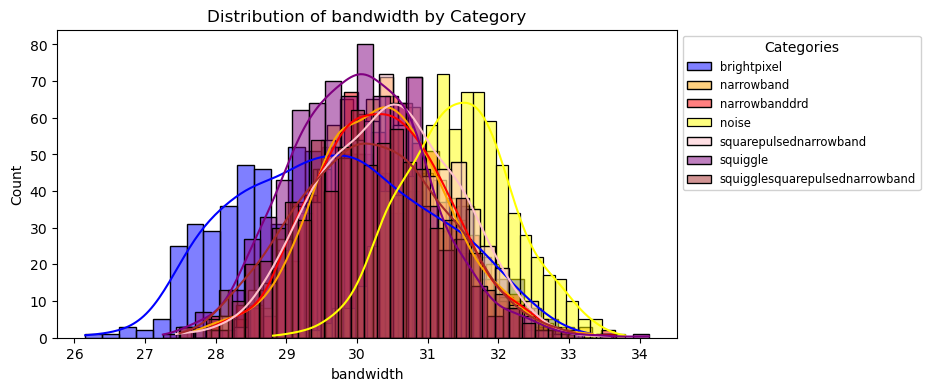

c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

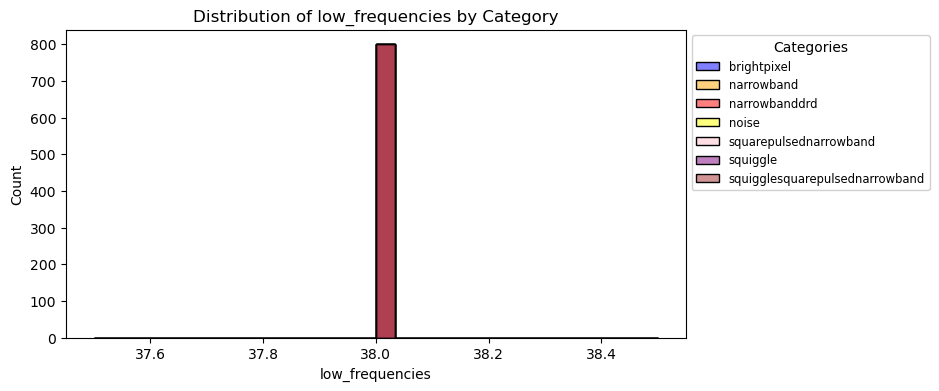

c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\koral\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

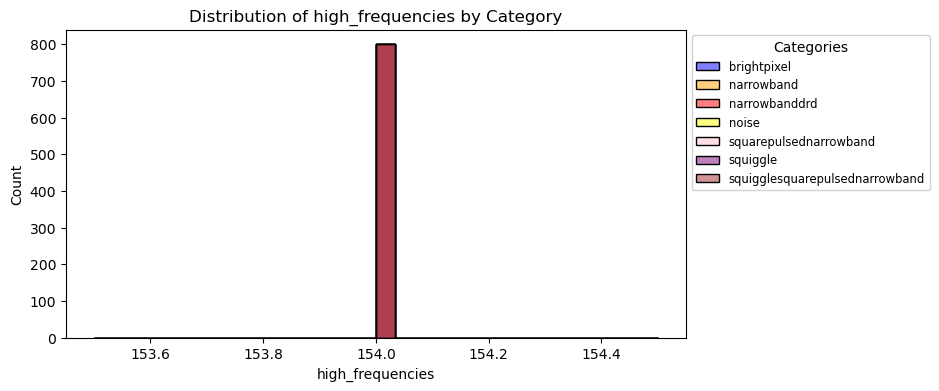

In [97]:
plot_features_distribution(['peak', 'spetcral_centroid', 'bandwidth', 'low_frequencies', 'high_frequencies'], fft_features_df)

Interesting! We plotted for each one of our chosen data samples their magnitude spectrums and their high and low frequencies. As expected, from our plotted data samples it looks like the cleaner the image is - the more high frequencies we found.

Now, let's calculate these features on our entire training set so we will try to conculde some interesting points:

In [ ]:
def determine_noise_level(cadence_id):
    if cadence_id in lowest_noise_images['id'].values:
        return 'low'
    elif cadence_id in median_noise_images['id'].values:
        return 'medium'
    elif cadence_id in highest_noise_images['id'].values:
        return 'high'
    return 'medium'

# Main    
frequencies_list = []

for _, row in training_set.iterrows():
    file_id = row['id']
    file_path = get_file_path(file_id, CFG.train_folder_path)
    cadence_snippet = np.load(file_path)

    _, low_frequencies, high_frequencies = extract_cadence_frequency_features(cadence_snippet)

    frequencies = {
        'low_frequencies': low_frequencies,
        'high_frequencies': high_frequencies,
        'noise_level': determine_noise_level(file_id),
        'id': file_id,
        'target': row['target']
    }

    frequencies_list.append(frequencies)

frequencies_df = pd.DataFrame(frequencies_list)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))
axes = axes.flatten()

for index, noise_level in enumerate(['low', 'medium', 'high']):
    noise_df = frequencies_df[frequencies_df['noise_level'] == noise_level]
        
    ax_low_frequencies = axes[index * 2] 
    sns.histplot(data=noise_df, x='low_frequencies', hue='target', kde=True, ax=ax_low_frequencies)
    ax_low_frequencies.set_title(f'{noise_level.capitalize()} Noise - Low Frequencies by Target')
    ax_low_frequencies.set_xlabel('Low Frequency')
    ax_low_frequencies.set_ylabel('Count')
        
    ax_high_frequencies = axes[index * 2 + 1]  
    sns.histplot(data=noise_df, x='high_frequencies', hue='target', kde=True, ax=ax_high_frequencies)
    ax_high_frequencies.set_title(f'{noise_level.capitalize()} Noise - High Frequencies by Target')
    ax_high_frequencies.set_xlabel('High Frequency')
    ax_high_frequencies.set_ylabel('Count')
    
plt.tight_layout()
plt.show()

Great! It looks like the **Low Frequencies** amount is pretty much the same between the different noise level images, the main different is the amount of the **High Frequencies** - The images with the lowest noise has 12,000-18,000 high frequencies in average, the medium noise images has 5,000-15,000 high frequencies in average and the images with the highest noise has 1,000-3,000 high frequencies in average. We don't know yet if the small amount of high frequencies is due to bad images quality or another reason. Anyway, as we already said: **in the further sections - we might decide to consider some of the highest noise samples as outliers and remove them from our training set**.

Let's take a look over a `correlation matrix` as well, to examine if there is a correlation between freqency type to noise level:
> **Correlation Matrix**: Helps understand the relationships between the variables in a dataset based on their correlation coefficients. The diagonal values in the correlation matrix will always be 1, as a variable is perfectly correlated with itself - But, the off-diagonal elements show the correlation between different pairs of variables.

In [ ]:
noise_level_mapping = {'low': 0, 'medium': 1, 'high': 2}
frequencies_df['noise_level_numeric'] = frequencies_df['noise_level'].map(noise_level_mapping)

correlation_matrix = frequencies_df[['low_frequencies', 'high_frequencies', 'noise_level_numeric']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

As we see, the correlation between `low_frequencies` to `noise_level` is 0.53 which is pretty moderate (one variable increases, the other variable also tends to increase, though not perfectly). Let's check the exact correlation between `high_frequencies` to `noise_level`:

In [ ]:
high_frequencies_to_noise = correlation_matrix.at['high_frequencies', 'noise_level_numeric']
print(f'High frequencies to noise level correlation is {high_frequencies_to_noise: .2f}')

The `high_frequencies` to `noise_level` is a moderate correlation as well and it means that the more noise we have, the less high frequncies we will probably have (and probably the harder to find the needles), just like we suspected.

#### <a id='2_4_3'>2.4.3 Wavelet Transform Analysis</a>

Unlike `FFT` algorithem, that provides a representation of the signal in the frequency domain - the `Wavelet Transform` provides a time-frequency representation of the signal. It is a mathematical tool used to analyze and represent signals by decomposing it into its high-frequency and low-frequency components. This is achieved by using **wavelets**, which are small waves localized in both time and frequency. These **wavelets** can be scaled and translated to capture different frequency components at various resolutions.

There are two main types of `Wavelet Transforms`:
-  **Continuous Wavelet Transform (CWT)**: which providing a detailed time-frequency analysis that is often redundant. This makes the `CWT` computationally intensive but highly effective for feature extraction and detailed signal analysis.
-  **Discrete Wavelet Transform (DWT)**: a sampled version of the `CWT`, offering a non-redundant and computationally efficient representation of the signal. The DWT is widely used in practical applications such as signal denoising, compression, and feature extraction.

We will use `DWT` in our analyzing, using `pywt.dwt2` - which output four components:
- **Approximation Coefficients (cA)**: These coefficients represent the low-frequency components of the spectrogram. They capture the overall structure or smooth features of the image - in the context of the spectrogram, `cA` would capture the general trend or average energy distribution over time and frequency.
- **Horizontal Detail Coefficients (cH)**: These coefficients represent the horizontal high-frequency components of the spectrogram. They capture horizontal edges and details, highlighting changes or variations in the horizontal direction - in the spectrogram, `cH` would emphasize sudden changes or transitions in frequency that occur horizontally across the time axis.
- **Vertical Detail Coefficients (cV)**: These coefficients as similar to the `cH`, but in the vertical direction.
- **Diagonal Detail Coefficients (cD)**: These coefficients as similar to the `cH`, but in the diagonal direction.

Let's start looking on these features in specific data samples using **Daubechies Wavelets** (the simplest wavelet type):

In [ ]:
def apply_dwt(spectrogram):
    coeffs2 = pywt.dwt2(spectrogram, 'db4')
    cA, (cH, cV, cD) = coeffs2

    return cA, cH, cV, cD

In [ ]:
def plot_cadence_snippet_with_dwt_components(cadence_snippet, title, figsize=(15,8)):
    _, axes = plt.subplots(nrows=6, ncols=5, figsize=figsize)
    axes[0, 0].set_title('Original spectrogram', fontsize=10)
    axes[0, 1].set_title('cA', fontsize=10)
    axes[0, 1].set_title('cH', fontsize=10)
    axes[0, 2].set_title('cV', fontsize=10)
    axes[0, 3].set_title('cD', fontsize=10)
    print(title)

    for i in range(6):
        spectrogram = cadence_snippet[i].astype('float32')
        cA, cH, cV, cD = apply_dwt(spectrogram)

        channel_text = 'on' if i % 2 == 0 else 'off'
        channel_box = dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')

        ax_spectrogram = axes[i, 0]
        ax_spectrogram.imshow(spectrogram, aspect='auto', cmap='gray')
        ax_spectrogram.text(20, 90, channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_spectrogram.axis('off')

        ax_ca = axes[i, 1]
        ax_ca.imshow(cA, aspect='auto', cmap='gray')
        ax_ca.axis('off')

        ax_ch = axes[i, 2]
        ax_ch.imshow(cH, aspect='auto', cmap='gray')
        ax_ch.axis('off')

        ax_cv = axes[i, 3]
        ax_cv.imshow(cV, aspect='auto', cmap='gray')
        ax_cv.axis('off')

        ax_cd = axes[i, 4]
        ax_cd.imshow(cD, aspect='auto', cmap='gray')
        ax_cd.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main
plot_cadence_snippet_with_dwt_components(np.load(get_file_path('0000799a2b2c42d', CFG.train_folder_path)), 'Here is a non-alien signals example:')
plot_cadence_snippet_with_dwt_components(np.load(get_file_path('d618b77bb0909c2', CFG.train_folder_path)), '\nHere is an easy alien signals example:')
plot_cadence_snippet_with_dwt_components(np.load(get_file_path('fffbb1c9c3d6c31', CFG.train_folder_path)), '\nHere is a hard alien signals example:')

Pretty cool! Looks like this decomposition works pretty well on horizontal and vertical lines. It also looks like **both of the alien signals, appreas in the vertical frequencies** (`cD`). It's a bit surprising, because we expected the diagonal frequencies to contains the needles signals.

Let's explore more the vertical and diagonal frequencies:

In [ ]:
def plot_cadence_snippet_with_dwt_components(cadence_snippet, figsize=(10,4)):
    _, axes = plt.subplots(nrows=6, ncols=3, figsize=figsize)
    axes[0, 0].set_title('Original spectrogram', fontsize=10)
    axes[0, 1].set_title('cV', fontsize=10)
    axes[0, 2].set_title('cD', fontsize=10)

    for i in range(6):
        spectrogram = cadence_snippet[i].astype('float32')
        _, _, cV, cD = apply_dwt(spectrogram)

        channel_text = 'on' if i % 2 == 0 else 'off'
        channel_box = dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')

        ax_spectrogram = axes[i, 0]
        ax_spectrogram.imshow(spectrogram, aspect='auto', cmap='gray')
        ax_spectrogram.text(20, 90, channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_spectrogram.axis('off')

        ax_cd = axes[i, 1]
        ax_cd.imshow(cV, aspect='auto', cmap='gray')
        ax_cd.text(7, 45, channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_cd.axis('off')

        ax_cd = axes[i, 2]
        ax_cd.imshow(cD, aspect='auto', cmap='gray')
        ax_cd.text(7, 45, channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_cd.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main
plot_cadence_snippet_with_dwt_components(np.load(f'{CFG.base_folder_path}/e1f7c0159caa.npy'))
plot_cadence_snippet_with_dwt_components(np.load(f'{CFG.base_folder_path}/7072ba75fac0.npy'))
plot_cadence_snippet_with_dwt_components(np.load(f'{CFG.base_folder_path}/01b9a614b8f1.npy'))

We plotted three more alien signals, in all of the images - the vertical frequencies indeed capture better these signals.

Now, let's take some statistics over the entire training set. For each of the *Vertical Coefficients*, *Diagonal Coefficients* we will extract:
- **Mean**: Measures the central value of the coefficients.
- **Variance**: Measures how spread out the coefficients are.

In [ ]:
def extract_coefficients_features(coefficients):
    coefficients_mean = np.mean(coefficients)
    coefficients_variance = np.var(coefficients)

    return coefficients_mean, coefficients_variance

def extract_cadence_wavelets_features(cadence_snippet):
    features = {
        'vertical_mean': 0,
        'vertical_variance': 0,
        'diagonal_mean': 0,
        'diagonal_variance': 0,
    }
    
    for i in range(6):
        spectrogram = cadence_snippet[i].astype('float32')
        _, _, cV, cD = apply_dwt(spectrogram)
        
        cv_mean, cv_variance = extract_coefficients_features(cV)
        cd_mean, cd_variance = extract_coefficients_features(cD)
        
        features['vertical_mean'] += cv_mean
        features['vertical_variance'] += cv_variance
        
        features['diagonal_mean'] += cd_mean
        features['diagonal_variance'] += cd_variance

    return features

In [ ]:
wavelets_list = []

for _, row in training_set.iterrows():
    file_id = row['id']
    file_path = get_file_path(file_id, CFG.train_folder_path)
    cadence_snippet = np.load(file_path)

    wavelets_features = extract_cadence_wavelets_features(cadence_snippet)

    wavelets_features['id'] = file_id
    wavelets_features['target'] = row['target']

    wavelets_list.append(wavelets_features)

wavelets_df = pd.DataFrame(wavelets_list)

Now, we can plot the results we've got:

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axes = axes.flatten()

for index, feature in enumerate(['mean', 'variance']): 
    ax_vertical = axes[index * 2] 
    sns.histplot(data=wavelets_df, x=f'vertical_{feature}', hue='target', kde=True, ax=ax_vertical)
    ax_vertical.set_title(f'{feature.capitalize()} Vertical by Target')
    ax_vertical.set_xlabel(feature.capitalize())
    ax_vertical.set_ylabel('Count')
        
    ax_diagonal = axes[index * 2 + 1] 
    sns.histplot(data=wavelets_df, x=f'diagonal_{feature}', hue='target', kde=True, ax=ax_diagonal)
    ax_diagonal.set_title(f'{feature.capitalize()} Diagonal by Target')
    ax_diagonal.set_xlabel(feature.capitalize())
    ax_diagonal.set_ylabel('Count')
    
plt.tight_layout()
plt.show()

We can see that again, **target 0 and target 1 have pretty much similar trends** in the variance and means graphs of vertical and diagonal coefficients.
We also can see that unlike the variance of the spectrograms pixels value, that was close to 1 - **the variance of the vertical coefficients is mostly between 0 - 12**, which is easier to work with.

Let's take a look on a correlation matrix as well:

In [ ]:
correlation_matrix = wavelets_df[['diagonal_mean', 'diagonal_variance', 'vertical_mean', 'vertical_variance', 'target']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Looks like there is **no correlation at all between any two variables** here. 

Let's try to explore some extreme vertical variance values:

In [ ]:
def plot_cadence_snippet_with_cv(cadence_snippet, figsize=(8,4)):
    _, axes = plt.subplots(nrows=6, ncols=2, figsize=figsize)
    axes[0, 0].set_title('Original spectrogram', fontsize=10)
    axes[0, 1].set_title('cV', fontsize=10)

    for i in range(6):
        spectrogram = cadence_snippet[i].astype('float32')
        _, _, cV, _ = apply_dwt(spectrogram)

        channel_text = 'on' if i % 2 == 0 else 'off'
        channel_box = dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')

        ax_spectrogram = axes[i, 0]
        ax_spectrogram.imshow(spectrogram, aspect='auto', cmap='gray')
        ax_spectrogram.text(20, 90, channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_spectrogram.axis('off')

        ax_cd = axes[i, 1]
        ax_cd.imshow(cV, aspect='auto', cmap='gray')
        ax_cd.text(7, 45, channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_cd.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_images_with_cv(images_id, title):
    print(title)

    for id in images_id:
        variance = wavelets_df.loc[wavelets_df['id'] == id, 'vertical_variance'].values[0]
        print(f'-- Image id {id} has variance of {variance}')

        cadence_snippet = np.load(get_file_path(id, CFG.train_folder_path))
        plot_cadence_snippet_with_cv(cadence_snippet)

# Main
lowests, median, highest = get_samples_by_threshold(wavelets_df, 'vertical_variance', 10, 90)
plot_images_with_cv(get_samples_id(lowests, 1, 1), 'Lowest Vertical Variance images:\n')
plot_images_with_cv(get_samples_id(median, 1, 1), 'Median Vertical Variance images:\n')
plot_images_with_cv(get_samples_id(highest, 1, 1), 'Highest Vertical Variance images:\n')

As we can see, there is a pretty noticable difference between the lowest and median vertical frequencies variance to the highest vertical frequencies variance. The highest variance images are mostly black images, with with lines and the other images has much more shades.

We've done analyzing our spectrograms frequencies. In the next sections, we will use `Wavelet Transform` and `Fourier Transform` techniques in order to clean noises from the images. And for now, let's move to do clustering:

### <a id='2_5'>2.5 Clustering</a>

In order to better understand the data we have been provided with, we need to divide it into categories. In the sections above, we divided the spectrograms to categories based on their noise level, but maybe - there are other intereseting divisions- like *different groups of alien signals* or *different groups of non-alien signals* and more. This division, can be done by using `clustering`. 

Clustering is a process of grouping similar objects together based on their characteristics or features. It is a fundamental unsupervised learning technique which widely used in various domains. It includes several steps:
- **Data Representation**: each data sample should be represented as a vector of features. In our case, we will try using feature extraction.
- **Dimensionality Reduction** (Optional): Sometimes, high-dimensional data can be complex to analyze directly. Dimensionality reduction techniques are used to reduce the number of features while preserving important patterns. We will try to use `PCA`
- **Choosing a Clustering Algorithm**: Select a clustering algorithm based on your data and objectives. Common algorithms include `K-means`, `hierarchical clustering`, and `DBSCAN`. We will try to use `K-means`
- **Run the Algorithm**: Apply the chosen clustering algorithm to the data

Let's start writing the code of a general clustering process, so we will use it later to cluster our signals samples:

#### <a id='2_5_1'>2.5.1 Data Representation</a>

In order to cluster our dataset we need to provide the clustering algorithm our data as one dimentional features vector. The simplest way for doing it, is to flatten our `(6, 273, 256)` cadence snippet into 1D vector in size of **6 * 273 * 256 = 419,328** by using `np.array`:

In [ ]:
def flatten_sample(data_sample):
    return data_sample.flatten()

def flatten_samples(data_samples):
    flattened_data_samples = [flatten_sample(data_sample) for data_sample in data_samples]

    return np.array(flattened_data_samples)

The problem with this way, is that the results are pretty large vectors. Although we can try using Dimensionality reduction methods - the larget the vectors are - the longer the calculation will take. In order to represent our data in a smaller vectors - we will try a few features extraction techniques:

##### <a id='2_5_1_1'> 2.5.1.1. Vertical Detail Coefficients (cV)</a>
In section *2.4.3*, we've been analyzed our cadence snippets frequencies component using `Wavelet Transformation` technique. During the analyzing, we saw that the `vertical coefficients` components of a spectrogram, capture pretty well the needles signals and remove a lot of static frequencies. In addition, `cV`representation has smaller dimensions - `(140, 131)`, which can be flatten into 1D vector in size of **6 * 140 * 131 = 110,040**. This can be a suitable option for us.

Let's start by writing a function that convert a cadence snippet to its spectrograms `cV` representation:

In [ ]:
def apply_cv(cadence_snippet_id):
    cadence_snippet = np.load(get_file_path(cadence_snippet_id, CFG.train_folder_path))
    cv_cadence_snippet = []

    for i in range(6):
        spectrogram = cadence_snippet[i]
        _, _, cV, _ = apply_dwt(spectrogram)
        cv_cadence_snippet.append(cV)

    return np.array(cv_cadence_snippet)

After invoking `apply_cv` function over a cadence snippet, we will use `flatten_sample` function to return it as 1D vector representation. 

This solution, might be good enough for our needs - but maybe there are better solutions in the feature extraction field, let's try a few of them:

##### <a id='2_5_1_1'> 2.5.1.2. SIFT</a>

`SIFT` (Scale-Invariant Feature Transform) is an algorithm used to detect and describe local features in images. It detects features that are invariant to scale, making it effective for images captured at different resolutions. The algorithm identifies **key points** in the image that are stable and distinctive, such as corners, edges, and blobs. For each keypoint, SIFT computes a **descriptor**, a 128-dimensional vector that **characterizes the local image region around the keypoint**. This descriptor is invariant to rotations and translations.


In [ ]:
def apply_sift(spectrogram):
    sift = cv2.SIFT_create()

    # Ensure the image is in uint8 format, which is required for SIFT
    if spectrogram.dtype != np.uint8:
        spectrogram = spectrogram.astype(np.uint8)

    keypoints, descriptors = sift.detectAndCompute(spectrogram, None)
    draw_keypoints = cv2.drawKeypoints(spectrogram, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return keypoints, descriptors, draw_keypoints

Now, let's try to plot `sift` results over some data samples:

In [ ]:
def plot_cadence_snippet_with_sift(cadence_snippet, figsize=(11,4), margin=(20,90)):
    _, axes = plt.subplots(nrows=6, ncols=2, figsize=figsize)
    axes[0, 0].set_title('Before SIFT', fontsize=10)
    axes[0, 1].set_title('After SIFT', fontsize=10)
    
    for i in range(6):
        spectrogram = cadence_snippet[i].astype(np.float32)
        keypoints, descriptors, draw_keypoints = apply_sift(spectrogram)
        print(f'Channel {i + 1}: there are {len(keypoints)} keypoints, with {descriptors.shape if descriptors is not None else (0, 0)} descriptors size')
        channel_text = 'on' if i % 2 == 0 else 'off'
        channel_box = dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')

        ax_spectrogram = axes[i, 0]
        ax_spectrogram.imshow(spectrogram, aspect='auto', cmap='gray')
        ax_spectrogram.text(margin[0], margin[1], channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_spectrogram.axis('off')

        ax_cd = axes[i, 1]
        ax_cd.imshow(draw_keypoints, aspect='auto', cmap='viridis')
        ax_cd.text(margin[0], margin[1], channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_cd.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main
plot_cadence_snippet_with_sift(np.load(get_file_path('0000799a2b2c42d', CFG.train_folder_path)))
plot_cadence_snippet_with_sift(np.load(get_file_path('d618b77bb0909c2', CFG.train_folder_path)))
plot_cadence_snippet_with_sift(np.load(get_file_path('fffbb1c9c3d6c31', CFG.train_folder_path)))

Thats does not look promising. The first non-alien cadence snippet is full of keypoints, and the alien cadence snippets does not have keypoints in the correct places. It will probably return better results, if some of the static frequencies will be removed using `apply_cv`:

In [ ]:
plot_cadence_snippet_with_sift(apply_cv('0000799a2b2c42d'), figsize=(11,4), margin=(10, 50))
plot_cadence_snippet_with_sift(apply_cv('d618b77bb0909c2'), figsize=(11,4), margin=(10, 50))
plot_cadence_snippet_with_sift(apply_cv('fffbb1c9c3d6c31'), figsize=(11,4), margin=(10, 50))

It looks better on the non-alien signal, but still not good enough for our needs - the descriptors have a larger dimensions that the `cV`, and much worse - it does not capture the needels at all.

We will move now to try a different popular feature extraction technique called `HOG`:

##### <a id='2_5_1_2'> 2.5.1.2. HOG</a>
**Histogram of Oriented Gradients** (HOG) is a feature descriptor used in computer vision for object detection. It works by dividing an image into small regions, computing the gradient directions within each region, and then creating a histogram of these orientations. By normalizing these histograms across larger regions, HOG captures the shape and appearance of objects in a way that is robust to changes in illumination and slight deformations

In [ ]:
def apply_hog(spectrogram):
    return hog(spectrogram, 
               orientations=9, 
               pixels_per_cell=(8, 8), 
               cells_per_block=(2, 2), 
               block_norm='L2-Hys', 
               visualize=True)

Now, we can plot some `hog` results for exploration, using the `apply_cv` first for noise removing:

In [ ]:
def plot_cadence_snippet_with_hog(cadence_snippet, figsize=(11,4), margin=(20,90)):
    _, axes = plt.subplots(nrows=6, ncols=2, figsize=figsize)
    axes[0, 0].set_title('Before HOG', fontsize=10)
    axes[0, 1].set_title('After HOG', fontsize=10)
    
    for i in range(6):
        spectrogram = cadence_snippet[i].astype(np.float32)
        hog_features, hog_image = apply_hog(spectrogram)

        if i ==0:
            print(f'All 6 channels have 1D hog features vector in size of {hog_features.shape[0]}')

        channel_text = 'on' if i % 2 == 0 else 'off'
        channel_box = dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')

        ax_spectrogram = axes[i, 0]
        ax_spectrogram.imshow(spectrogram, aspect='auto', cmap='gray')
        ax_spectrogram.text(margin[0], margin[1], channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_spectrogram.axis('off')

        ax_cd = axes[i, 1]
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        ax_cd.imshow(hog_image_rescaled, aspect='auto', cmap='gray')
        ax_cd.text(margin[0], margin[1], channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_cd.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main
plot_cadence_snippet_with_hog(apply_cv('0000799a2b2c42d'), figsize=(11,4), margin=(10, 50))
plot_cadence_snippet_with_hog(apply_cv('d618b77bb0909c2'), figsize=(11,4), margin=(10, 50))
plot_cadence_snippet_with_hog(apply_cv('fffbb1c9c3d6c31'), figsize=(11,4), margin=(10, 50))

The hog results are even worse. Although the results have smaller dimensions, it does not seem like it captures the alien signals at all.

We should move to our last try - a technique called `LBP`:

##### <a id='2_5_1_3'> 2.5.1.3. LBP</a>

`Local Binary Patterns` (LBP) is a texture descriptor that labels the pixels of an image by thresholding the neighborhood of each pixel and treating the result as a binary number. It is particularly effective for texture classification, capturing local texture information by comparing each pixel with its surrounding neighbors. 
The `LBP` calculation is based on two parameters - **radius** and **n_points**:
- **radius** affects the pixel neighborhood that included in the calculation (radius = 1 contains pixels that are directly adjacent to the central pixel, when using a bigger radius - the neighborhood will be bigger as well)
- **n_points** represent the number of sampling points around the central pixel within the specified radius, its typically defined as *8 * radius*

In [ ]:
def apply_lbp(spectrogram):
    radius = 1  
    n_points = 8 * radius  
    spectrogram_uint8 = (spectrogram * 255).astype(np.uint8)

    return local_binary_pattern(spectrogram_uint8, n_points, radius, method='uniform')

In [ ]:
def plot_cadence_snippet_with_lbp(cadence_snippet, figsize=(11,4), margin=(20,90)):
    _, axes = plt.subplots(nrows=6, ncols=2, figsize=figsize)
    axes[0, 0].set_title('Before LBP', fontsize=10)
    axes[0, 1].set_title('After LBP', fontsize=10)
    
    for i in range(6):
        spectrogram = cadence_snippet[i].astype(np.float32)
        lbp = apply_lbp(spectrogram)

        if i == 0 :
            print(f'All 6 channels have 2D lbp features vector in size of {lbp.shape}')

        channel_text = 'on' if i % 2 == 0 else 'off'
        channel_box = dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')

        ax_spectrogram = axes[i, 0]
        ax_spectrogram.imshow(spectrogram, aspect='auto', cmap='gray')
        ax_spectrogram.text(margin[0], margin[1], channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_spectrogram.axis('off')

        ax_cd = axes[i, 1]
        ax_cd.imshow(lbp, aspect='auto', cmap='gray')
        ax_cd.text(margin[0], margin[1], channel_text, color='black', fontsize=8, va='center', ha='center', bbox=channel_box)
        ax_cd.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main
plot_cadence_snippet_with_lbp(apply_cv('0000799a2b2c42d'), figsize=(11,4), margin=(10, 50))
plot_cadence_snippet_with_lbp(apply_cv('d618b77bb0909c2'), figsize=(11,4), margin=(10, 50))
plot_cadence_snippet_with_lbp(apply_cv('fffbb1c9c3d6c31'), figsize=(11,4), margin=(10, 50))

The results of the `LBP` is just fine. its dimesions size equals to `cV`dimensions size and its indeed capture the needles signals, but provide a muhc more noisey image than using `cV` only. After trying 4 different popular feature extraction techniques for our cadence snippets representation, we can choose to use flatten `cV` only as our best data representation and move to our next `clustring` step:

#### <a id='2_5_1'>2.5.2 Dimensionality Reduction - PCA</a>

Now, we can move to preforme **Dimensionality Reduction** using `PCA`. `PCA` stands for Principal Component Analysis, a widely used technique that compute the covariance matrix of the data, choose the top k eigenvectors (principal components) corresponding to the largest eigenvalues and project the data onto the selected principal components.

By using `explained_variance_ratio_` metric, we will be able to assess how much of the total variance in our data is captured by each principal component, ensuring we preserve the most important features of the data while potentially reducing dimensionality:

In [ ]:
def pca(data_samples, n):
    pca = PCA(n_components=n)
    pca.fit(data_samples)

    return np.cumsum(pca.explained_variance_ratio_)

def plot_explained_variance(cum_explained_variance, n, sparsity = 1):
    indices = np.arange(n) + 1

    sparse_indices = [1] + list(range(sparsity, indices[-1] + 1, sparsity))
    
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=indices, y=cum_explained_variance, marker='o', color='b')
    plt.xlabel('Principal Component', fontsize=10)
    plt.ylabel('Cumulative Explained Variance', fontsize=10)
    plt.xticks(ticks=[indices.tolist().index(si) for si in sparse_indices], 
               labels=[str(si) for si in sparse_indices], 
               rotation=0)
    
    plt.show()

# Main
training_set_labels_samples = get_data_set_sample(training_set, 50, 0.1)
training_set_samples = []

for file_id in training_set_labels_samples['id']:
    cv_cadence_snippet = apply_cv(file_id)
    training_set_samples.append(np.vstack(cv_cadence_snippet))

training_set_flatten_samples = flatten_samples(training_set_samples)
cum_explained_variance = pca(training_set_flatten_samples, 30)
plot_explained_variance(cum_explained_variance, 30)

Although we only ran this code over 50 samples, we can learn two interesting things:
- In order to get good ratio of retained variance, the size of `n` should be pretty big in relation to the amount of samples. 
- This basic `PCA` code we've written won'y be good enough when dealing with large amount of data, it keeps all the data sample in the program memory and does all the calculations in one shot - which can cause our app to crash.

Now, we will try writing the `PCA` process again using batched `IncrementalPCA` and run it over **all the alien samples** (6,000 samples): 

In [ ]:
def get_flattened_data(files_id):
    data_list = []
    for file_id in files_id:
        data = apply_cv(file_id)
        data_list.append(np.vstack(data).flatten())
    return np.array(data_list)

def batched_pca_fit(files_id, pca, batch_size):
    for start_index in range(0, len(files_id), batch_size):
        end_index = min(start_index + batch_size, len(files_id))
        batched_files = files_id[start_index:end_index]
        batched_data = get_flattened_data(batched_files)

        # Ensure there are enough samples for PCA
        if batched_data.shape[0] >= pca.n_components:
            pca.partial_fit(batched_data)

def batched_pca_transform(files_id, pca, batch_size):
    transformed_data_list = []

    for start_index in range(0, len(files_id), batch_size):
        end_index = min(start_index + batch_size, len(files_id))
        batched_files = files_id[start_index:end_index]
        batched_data = get_flattened_data(batched_files)

        # Ensure there are enough samples for PCA
        if batched_data.shape[0] >= pca.n_components:
            transformed_data_list.append(pca.transform(batched_data))

    return np.vstack(transformed_data_list)

def run_batched_pca(n_components, batch_size, data_samples):
    pca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
    files_id = data_samples['id'].values

    batched_pca_fit(files_id, pca, batch_size)
    transformed_data = batched_pca_transform(files_id, pca, batch_size)
    
    print(f'For n={n_components} - Total variance explained by all components: {np.sum(pca.explained_variance_ratio_)}')

    return transformed_data, pca.explained_variance_ratio_

# Main
batch_size = 1500
n_components = batch_size

train_alien_samples = training_set[training_set['target'] == 1]
test_alien_samples = testing_set[testing_set['target'] == 1]
alien_samples = pd.concat([train_alien_samples, test_alien_samples], ignore_index=True)

transformed_data, explained_variance = run_batched_pca(n_components, batch_size, alien_samples)
plot_explained_variance(np.cumsum(explained_variance), n_components, sparsity=100)

The `PCA` succeeded to reduce the data shape from `(6000, 110040)` to `(6000, 1500)` in a pretty decent variance retain. As we can see in the plot, it takes a large amount of principal components in order to step of from 0.8 retian variance ratio to 0.9+.

For now, it looks like we can keep using this dimensionality reduction technique and move forward to the `K-means` itself:

#### <a id='2_5_3'>2.5.3 K-means</a>
`K-means` clustering algorithm is an iterative algorithm used to partition data into k distinct clusters based on feature similarity.

This algorithm consist a few steps:
1. **Initialization**: The algorithm begins by selecting k initial centroids randomly from the data points.
2. **Assignment**: Each data point is assigned to the nearest centroid, creating k clusters.
3. **Update**: The centroids of the clusters are recalculated as the mean of all data points assigned to each cluster.
4. **Iteration**: Steps 2 and 3 are repeated until the centroids stabilize (i.e., they do not change significantly) or a maximum number of iterations is reached.

For a better understanding, here its workflow:

<img src="https://preview.redd.it/wodjl2e8ffw71.png?width=1121&format=png&auto=webp&s=1a723f05e981efee1519c4999c95c6611c587c0f" width="600"/>

Now, we will write a code that preforme this clustering, using `MiniBatchKMeans` for preforming it in batches:

In [ ]:
def batched_kmeans_fit(data_samples, n_clusters, batch_size):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)

    for start_index in range(0, len(data_samples), batch_size):
        end_index = min(start_index + batch_size, len(data_samples))
        batch_data = data_samples[start_index:end_index]
        kmeans.partial_fit(batch_data)
    
    return kmeans

def batched_kmeans_predictions(kmeans, data_samples, batch_size):
    predictions = []
    
    for start_index in range(0, len(data_samples), batch_size):
        end_index = min(start_index + batch_size, len(data_samples))
        batch_data = data_samples[start_index:end_index]
        predictions.extend(kmeans.predict(batch_data))
    
    return np.array(predictions)

def run_batched_kmeans(data_samples, n_clusters, batch_size):
    kmeans_model = batched_kmeans_fit(data_samples, n_clusters, batch_size)
    predictions = batched_kmeans_predictions(kmeans_model, data_samples, batch_size)

    return kmeans_model, predictions

Great! now it's time to choose our number of clusters - `k`. For doing it, we will use `Silhouette Score` method:
> **Silhouette Score**: computes the silhouette score (measures how similar data point is to its own cluster compared to other clusters) for each data point and choose the optimal `k` that maximize this averege data points score 

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2,11)

for k in k_range:
    kmeans_model, clusters = run_batched_kmeans(transformed_data, k, 250)
    
    score = silhouette_score(transformed_data, clusters)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Great! now, we can preforme `k-means` over k=2 and k=5:

In [ ]:
def plot_kmeans_clusters(data_samples_reduced, clusters, k):
    print(f'Clustering for k={k}:')
    cluster_counts = np.bincount(clusters)

    for cluster_id, count in enumerate(cluster_counts):
        print(f'-- Cluster {cluster_id + 1}: {count} items')

    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(data_samples_reduced[:, 0], data_samples_reduced[:, 1], c=clusters, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, ticks=range(k))
    plt.show()

# Main
batch_size = 300
kmeans_model_2, predictions_2 = run_batched_kmeans(transformed_data, 2, batch_size)
kmeans_model_3, predictions_3 = run_batched_kmeans(transformed_data, 3, batch_size)
kmeans_model_5, predictions_5 = run_batched_kmeans(transformed_data, 5, batch_size)

plot_kmeans_clusters(transformed_data, predictions_2, 2)
plot_kmeans_clusters(transformed_data, predictions_3, 3)
plot_kmeans_clusters(transformed_data, predictions_5, 5)

In [ ]:
def plot_candece_snippet_by_clusters(n_clusters, predictions, data_samples, samples_per_cluster):
    for cluster in range(n_clusters):
        cluster_indices = np.where(predictions == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, samples_per_cluster, replace=False)

        selected_spectrograms_id = data_samples.iloc[selected_indices]['id'].values
        selected_spectrograms = np.array([np.load(get_file_path(id, CFG.train_folder_path)) for id in selected_spectrograms_id])

        print(f'Cluster number {cluster + 1}:')
        plot_multiple_cadence_snippets(selected_spectrograms, figsize=(17,15))

# Main
plot_candece_snippet_by_clusters(n_clusters, predictions, alien_samples, 9)